<a href="https://colab.research.google.com/github/Richard-CYao/Analysing-learning-Data-in-2020/blob/main/Analyse_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Getting An Overview of the Dataset**


I download these data from kaggle in a folder named Learning Data. If you want, you can also download data from this URL: https://www.kaggle.com/competitions/learnplatform-covid19-impact-on-digital-learning/overview

These data are mainly divided into three:

*   **The engagement_data** folder is about a set of daily edtech engagement data from over 200 school districts in 2020.

*   **The products_info** file includes information about the characteristics of the top 372 products with most users in 2020.

*   **The districts_info** file includes information about the characteristics of school districts, including data from NCES and FCC.

By previewing these files, we can connect them through two columns: **district_id **and  **lp_id**. 
Now, I will show them visually through the following pictures.

In [ ]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

districts_info = pd.read_csv("/content/drive/MyDrive/Learning Data/districts_info.csv")
products_info = pd.read_csv("/content/drive/MyDrive/Learning Data/products_info.csv")

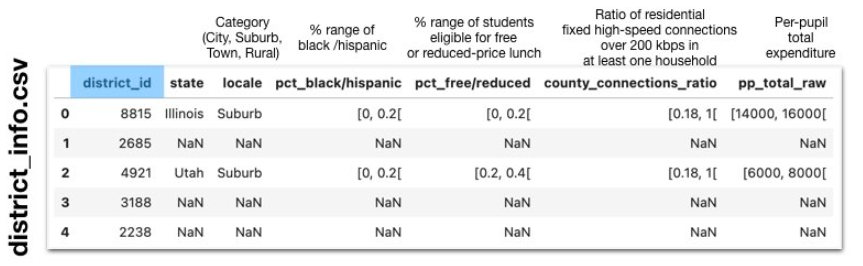

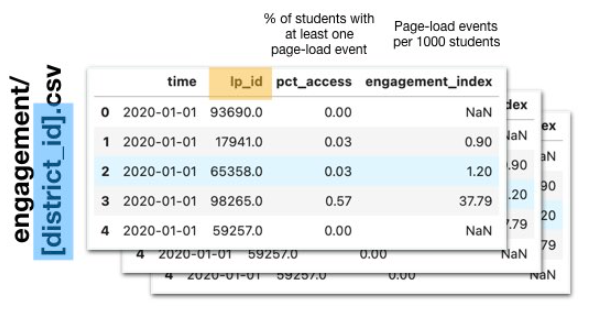

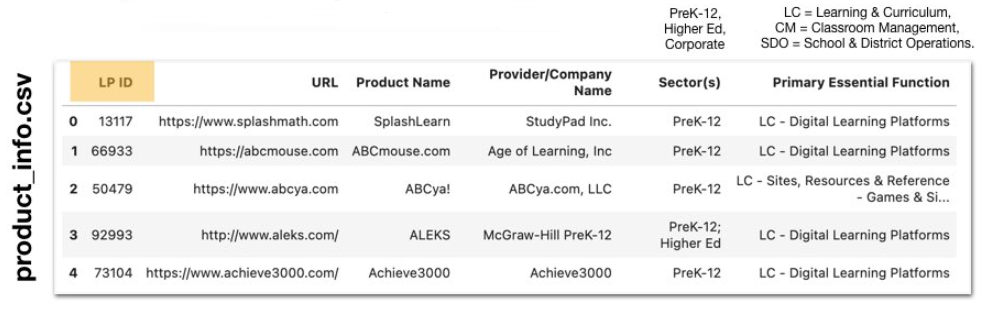

###**Preprocessing**

In the following subsections, I will proceed with the following basic preprocessing steps:

*   dropping 57 school districts with NaN states (57/233 ~ 25%)
*   one-hot encoding the product sectors
*   splitting up the primary essential function into main and sub category

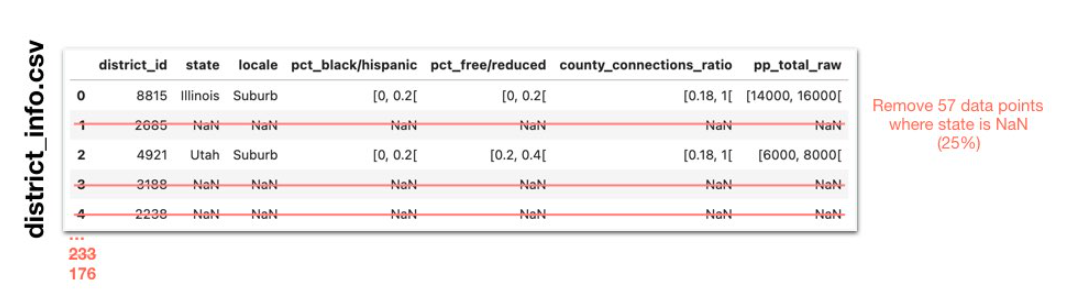

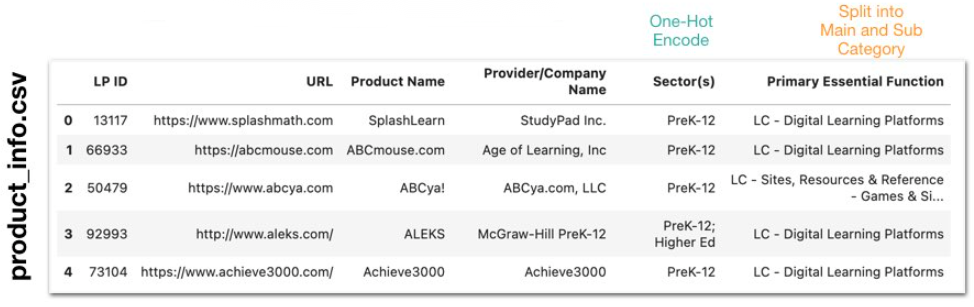

In [ ]:
#Dropping Districts with NaN States
districts_info = districts_info[districts_info.state.notna()].reset_index(drop=True)  

#One-Hot Encoding the Product Sectors
temp_sectors = products_info['Sector(s)'].str.get_dummies(sep="; ")
temp_sectors.columns = [f"sector_{re.sub(' ', '', c)}" for c in temp_sectors.columns]
products_info = products_info.join(temp_sectors)
products_info.drop("Sector(s)", axis=1, inplace=True)

del temp_sectors

#Splitting up the Primary Essential Function
products_info['primary_function_main'] = products_info['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if x == x else x)
products_info['primary_function_sub'] = products_info['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if x == x else x)
products_info['primary_function_sub'] = products_info['primary_function_sub'].replace({'Sites, Resources & References' : 'Sites, Resources & Reference'}) #Synchronize similar values

products_info.drop("Primary Essential Function", axis=1, inplace=True)


After preprocessing, we are left with a reduced districts_info dataframe with 176 districts and the product_info dataframe looks are follows:

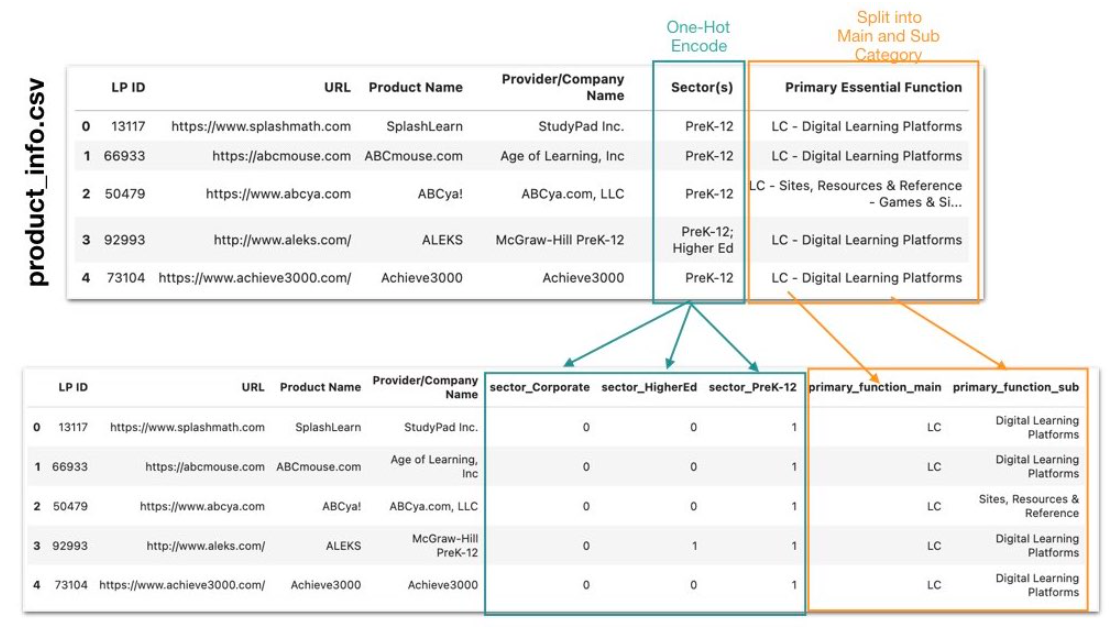

Then, I will add the "district_id" column to every file, which is in engagement_data folder, and let them in the same dataframe. 

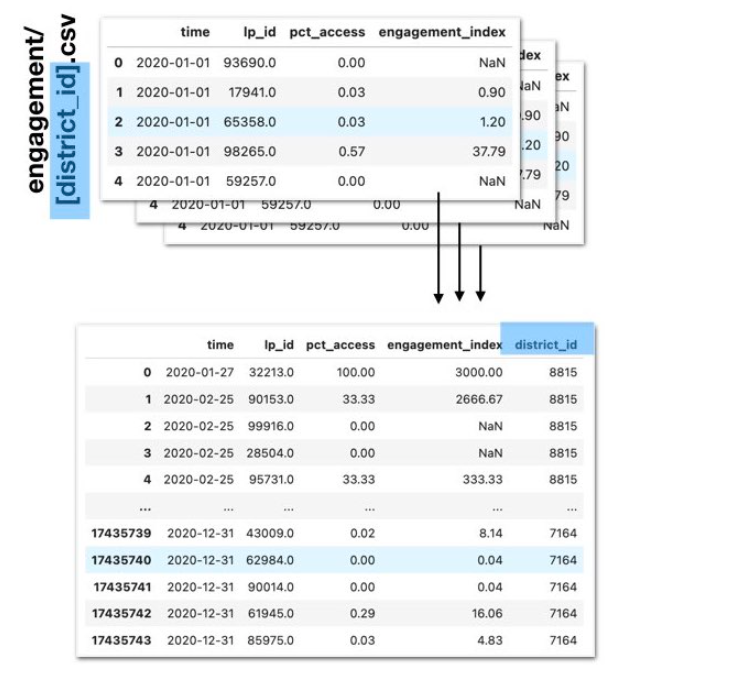

In [ ]:
PATH = "/content/drive/MyDrive/Learning Data/engagement_data"

temp = []

for district in districts_info.district_id.unique():
    df = pd.read_csv(f'{PATH}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    temp.append(df)
    
    
engagement = pd.concat(temp)
engagement = engagement.reset_index(drop=True)

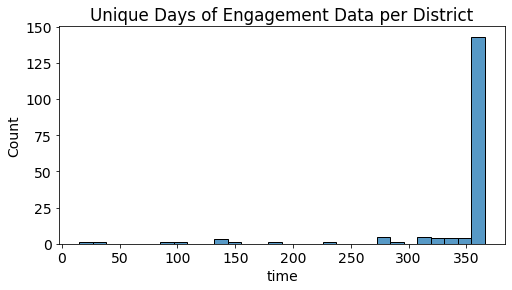

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(engagement.groupby('district_id').time.nunique(), bins=30)
ax.set_title('Unique Days of Engagement Data per District') # you will find that the days student enjoy online course in different district are all over 350.
plt.show()

To make the data easier to compare, we will only consider the regions with daily participation data in 2020

In [ ]:
# Delete previously created engagement dataframe and create a new one
del engagement

temp = []

for district in districts_info.district_id.unique():
    df = pd.read_csv(f'{PATH}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    if df.time.nunique() == 366:
        temp.append(df)

engagement = pd.concat(temp)
engagement = engagement.reset_index(drop=True)

# Only consider districts with full 2020 engagement data
districts_info = districts_info[districts_info.district_id.isin(engagement.district_id.unique())].reset_index(drop=True)
products_info = products_info[products_info['LP ID'].isin(engagement.lp_id.unique())].reset_index(drop=True)

Participation data for unknown products will be deleted. This reduces participation data by about half.

In [ ]:
for district in districts_info.district_id.unique()[:10]:
    df = pd.read_csv(f'{PATH}/{district}.csv', index_col=None, header=0)
    print(f'District {district} uses {df.lp_id.nunique()} unique products.')
    
print(f'\nConcatenated engagement data contains {engagement.lp_id.nunique()} unique products.')

District 3710 uses 985 unique products.
District 7177 uses 4913 unique products.
District 9812 uses 5056 unique products.
District 6584 uses 3508 unique products.
District 1044 uses 5593 unique products.
District 7457 uses 4013 unique products.
District 1904 uses 2200 unique products.
District 5527 uses 4055 unique products.
District 7614 uses 4468 unique products.
District 2779 uses 3644 unique products.

Concatenated engagement data contains 8417 unique products.


In [ ]:
print(len(engagement))
engagement = engagement[engagement.lp_id.isin(products_info['LP ID'].unique())] # delete data
print(len(engagement))

14913939
7784803


After that, I want to convert the time column to datetime64 [ns] for processing.

In [ ]:
engagement.time = engagement.time.astype('datetime64[ns]')

### Analyse Data

First, we can analyze the diversity of existing school districts.

In [ ]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

districts_info['state_abbrev'] = districts_info['state'].replace(us_state_abbrev) # abbreviate the names
districts_info_by_state = districts_info['state_abbrev'].value_counts().to_frame().reset_index(drop=False) # Count the number of school districts in each state
districts_info_by_state.columns = ['state_abbrev', 'num_districts']

fig = go.Figure()
layout = dict(
    title_text = "Number of Available School Districts per State",
    geo_scope='usa',
)

fig.add_trace(
    go.Choropleth(
        locations=districts_info_by_state.state_abbrev,
        zmax=1,
        z = districts_info_by_state.num_districts, # the number of school districts
        locationmode = 'USA-states', 
        marker_line_color='white', 
        geo='geo',
        colorscale=px.colors.sequential.Teal, 
    )
)
            
fig.update_layout(layout)   
fig.show()

Analyze the using situation in  different locales (languages, cities, suburbs, towns and countrysides.)

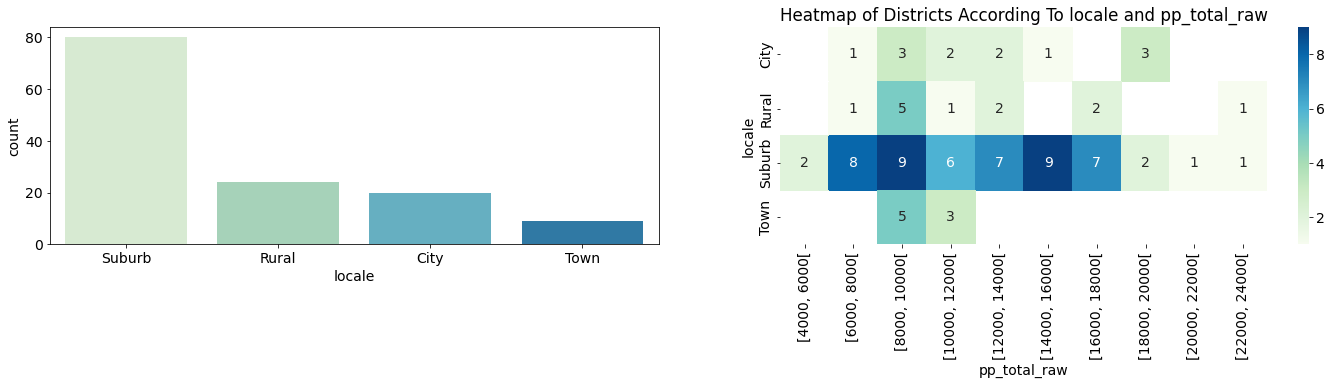

In [ ]:
districts_info.pp_total_raw.unique()
temp = districts_info.groupby('locale').pp_total_raw.value_counts().to_frame()
temp.columns = ['amount']

temp = temp.reset_index(drop=False)

temp = temp.pivot(index='locale', columns='pp_total_raw')['amount']
temp = temp[['[4000, 6000[', '[6000, 8000[', '[8000, 10000[', '[10000, 12000[',
       '[12000, 14000[', '[14000, 16000[', '[16000, 18000[', 
       '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', ]]


fig, ax = plt.subplots(1, 2, figsize=(24,4))

sns.countplot(data=districts_info, x='locale', ax=ax[0], palette='GnBu')

sns.heatmap(temp, annot=True,  cmap='GnBu', ax=ax[1])
ax[1].set_title('Heatmap of Districts According To locale and pp_total_raw')
plt.show()

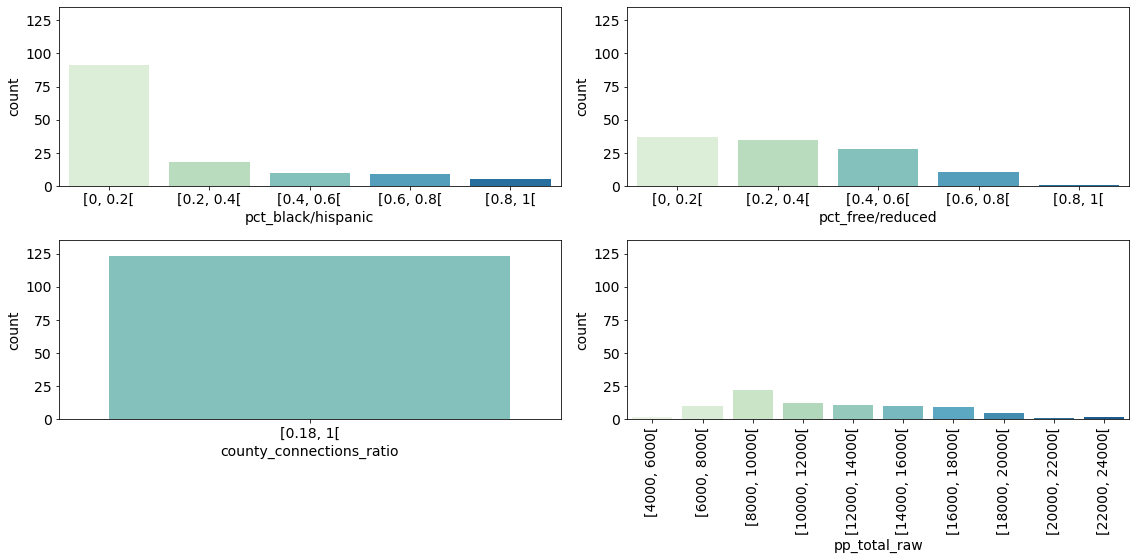

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16,8)) # 2,2 4张图， 1,1 1,2 2,1 2,2 

sns.countplot(data=districts_info, x='pct_black/hispanic', order=['[0, 0.2[', '[0.2, 0.4[', '[0.4, 0.6[', '[0.6, 0.8[','[0.8, 1[', ], palette='GnBu', ax=ax[0,0])
ax[0,0].set_ylim([0,135])
sns.countplot(data=districts_info, x='pct_free/reduced', order=['[0, 0.2[', '[0.2, 0.4[', '[0.4, 0.6[', '[0.6, 0.8[','[0.8, 1[', ], palette='GnBu', ax=ax[0,1])
ax[0,1].set_ylim([0,135])

sns.countplot(data=districts_info, x='county_connections_ratio', palette='GnBu', ax=ax[1,0])
ax[1,0].set_ylim([0,135])
sns.countplot(data=districts_info, x='pp_total_raw', order=['[4000, 6000[', '[6000, 8000[', '[8000, 10000[', '[10000, 12000[',
       '[12000, 14000[', '[14000, 16000[', '[16000, 18000[', 
       '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', ], palette='GnBu', ax=ax[1,1])
ax[1,1].set_ylim([0,135])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
def replace_ranges_pct(range_str):
    if range_str == '[0, 0.2[':
        return 0.1
    elif range_str == '[0.2, 0.4[':
        return 0.3
    elif range_str == '[0.4, 0.6[':
        return 0.5
    elif range_str == '[0.6, 0.8[':
        return 0.7
    elif range_str == '[0.8, 1[':
        return 0.9
    else:
        return np.nan
    
def replace_ranges_raw(range_str):
    if range_str == '[4000, 6000[':
        return 5000
    elif range_str == '[6000, 8000[':
        return 7000
    elif range_str == '[8000, 10000[':
        return 9000
    elif range_str == '[10000, 12000[':
        return 11000
    elif range_str ==  '[12000, 14000[':
        return 13000
    elif range_str ==  '[14000, 16000[':
        return 15000
    elif range_str == '[16000, 18000[':
        return 17000
    elif range_str ==  '[18000, 20000[':
        return 19000
    elif range_str ==  '[20000, 22000[':
        return 21000
    elif range_str ==  '[22000, 24000[':
        return 21000
    else: 
        return np.nan
    
districts_info['pct_black_hispanic_num'] = districts_info['pct_black/hispanic'].apply(lambda x: replace_ranges_pct(x))
districts_info['pct_free_reduced_num'] = districts_info['pct_free/reduced'].apply(lambda x: replace_ranges_pct(x))
districts_info['pp_total_raw_num'] = districts_info['pp_total_raw'].apply(lambda x: replace_ranges_raw(x))

def plot_state_mean_for_var(col):
    temp = districts_info.groupby('state_abbrev')[col].mean().to_frame().reset_index(drop=False)

    fig = go.Figure()
    layout = dict(
        title_text = f"Mean {col} per State",
        geo_scope='usa',
    )

    fig.add_trace(
        go.Choropleth(
            locations=temp.state_abbrev,
            zmax=1,
            z = temp[col],
            locationmode = 'USA-states', 
            marker_line_color='white',
            geo='geo',
            colorscale=px.colors.sequential.Teal, 
        )
    )

    fig.update_layout(layout)   
    fig.show()

plot_state_mean_for_var('pct_black_hispanic_num') # Percentage of school district students identified as black or Hispanic based on 2018-19 NCES data
plot_state_mean_for_var('pct_free_reduced_num') # Percentage of district students eligible for free or reduced lunch
plot_state_mean_for_var('pp_total_raw_num') # Total expenditure per student

We will now analyze the basic functions mainly used by students.

We can find that the most common category is Learning and Curriculum (LC), as shown in the left figure below. For the Classroom Management (CM) and School and District Operations (SDO) categories, much fewer tool options are available.

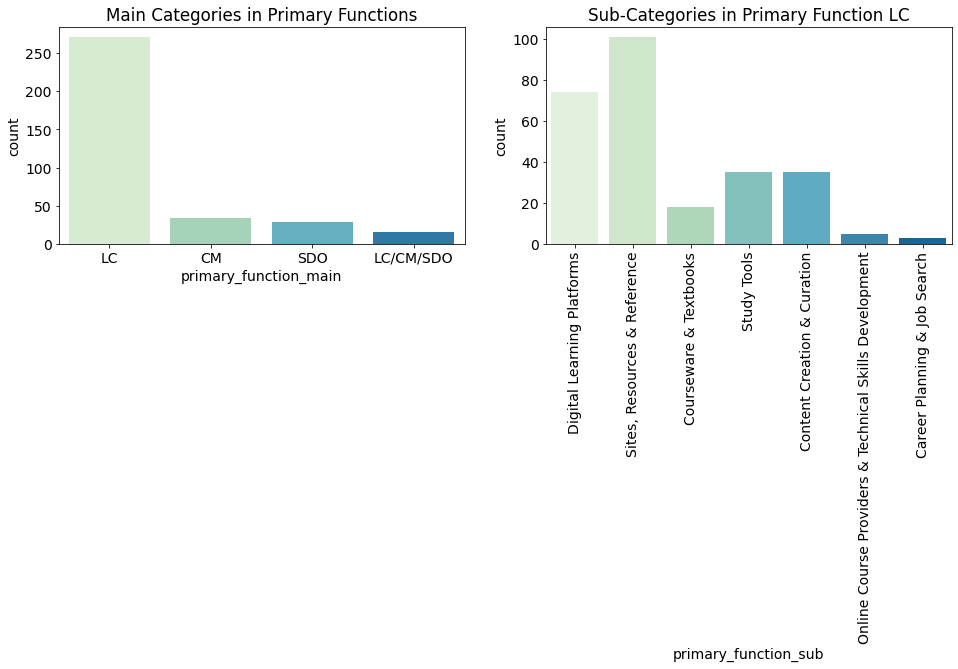

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.countplot(data=products_info, x='primary_function_main', palette ='GnBu', ax=ax[0])
ax[0].set_title('Main Categories in Primary Functions')

sns.countplot(data=products_info[products_info.primary_function_main == 'LC'], x='primary_function_sub', palette ='GnBu', ax=ax[1])
ax[1].set_title('Sub-Categories in Primary Function LC')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

Now we will try to think about  pct_ access and engagement_ index:

*   pct_ access : indicates how many students visit this application every day
*   engagement_ index : how many students participate in the application every day

Meanwhile, I delete weekend data because students have no course in weekend.

So, we see the first picture below and will find:

*   The family education stage starts in early March
*   There is summer vacation in July and August, so there is no class
*   After summer vacation, pct_ access increased to a higher level observed at the beginning of the pandemic and remained at a certain level
*    Zoom and Meet seem to be the two most popular products of virtual classroom



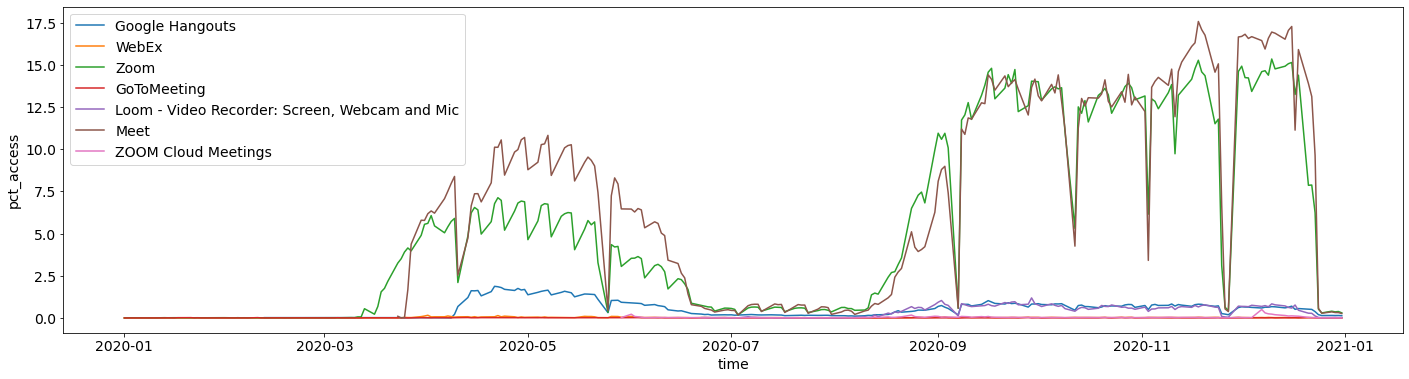

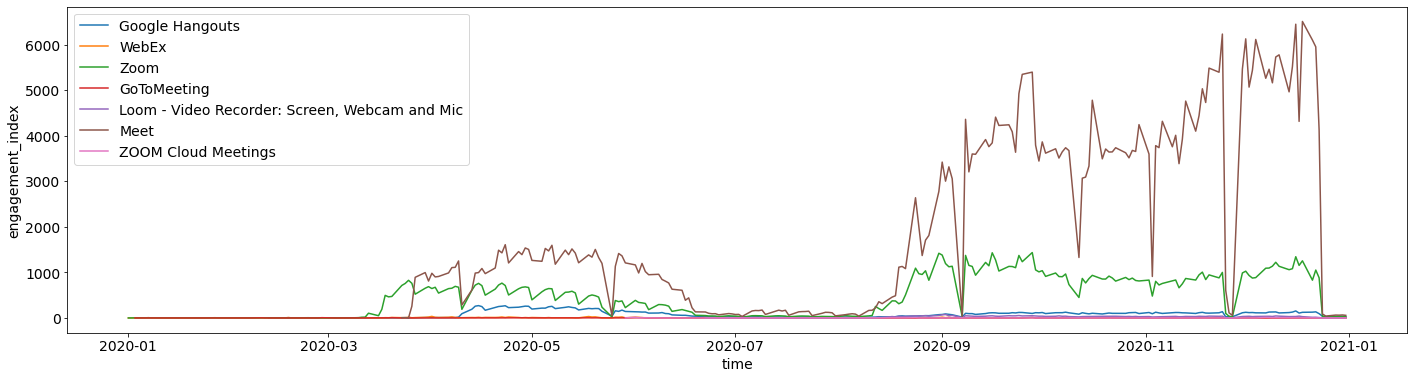

In [ ]:
virtual_classroom_lp_id = products_info[products_info.primary_function_sub == 'Virtual Classroom']['LP ID'].unique()

# Remove weekends from the dataframe
engagement['weekday'] = pd.DatetimeIndex(engagement['time']).weekday 
engagement_without_weekends = engagement[engagement.weekday < 5]

# Figure 1
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for virtual_classroom_product in virtual_classroom_lp_id:
    temp = engagement_without_weekends[engagement_without_weekends.lp_id == virtual_classroom_product].groupby('time').pct_access.mean().to_frame().reset_index(drop=False)
    sns.lineplot(x=temp.time, y=temp.pct_access, label=products_info[products_info['LP ID'] == virtual_classroom_product]['Product Name'].values[0])
plt.legend()
plt.show()

# Figure 2
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for virtual_classroom_product in virtual_classroom_lp_id:
    temp = engagement_without_weekends[engagement_without_weekends.lp_id == virtual_classroom_product].groupby('time').engagement_index.mean().to_frame().reset_index(drop=False)
    sns.lineplot(x=temp.time, y=temp.engagement_index, label=products_info[products_info['LP ID'] == virtual_classroom_product]['Product Name'].values[0])
plt.legend()
plt.show()

Next, we can see the top five products with the highest traffic volume in each LC subcategory, sorted by the average "pct_access" of all regions in 2020.

We can see that, on average, less than 5% of students visit most products every day. Except YouTube, Google Docs and Canvas.

In my opinion, the data of YouTube and Canvas are useless because YouTube can be used to leisure besides study and Canvas is actually a systerm for learning management.

Google Docs is a set of online office software, including online documents, forms and presentations, which meets the needs of students' daily online learning.

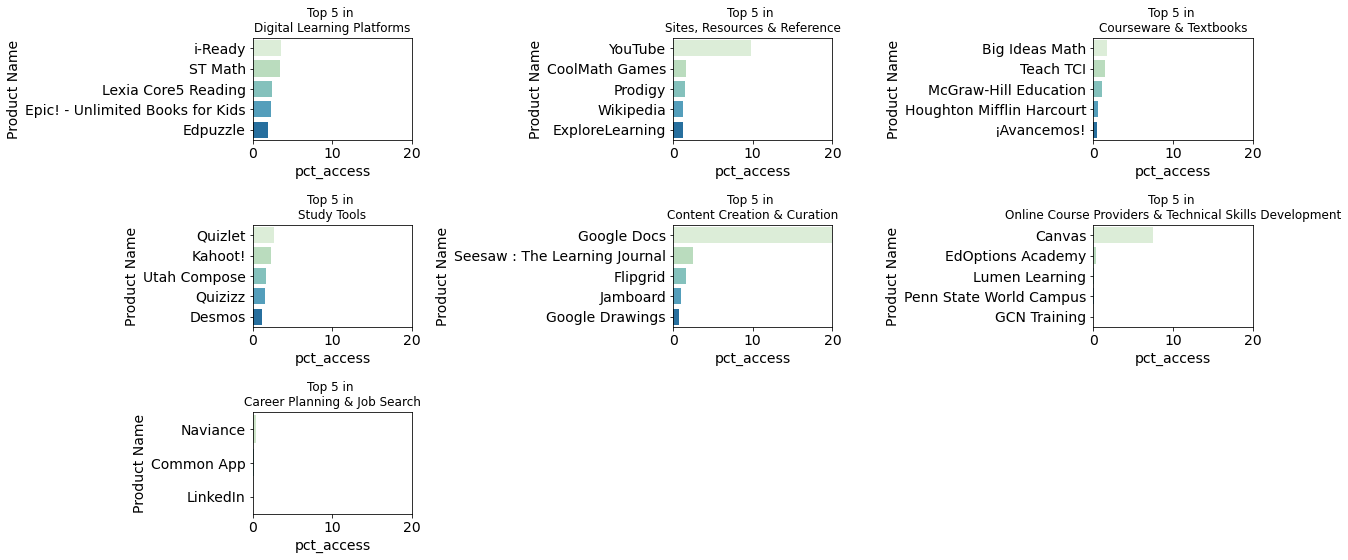

In [ ]:
products_info['lp_id'] = products_info['LP ID'].copy()

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))

i = 0
j = 0
for subfunction in products_info[products_info.primary_function_main == 'LC'].primary_function_sub.unique():
    lp_ids = products_info[products_info.primary_function_sub == subfunction]['LP ID'].unique()

    temp = engagement_without_weekends[engagement_without_weekends.lp_id.isin(lp_ids)]
    temp = temp.groupby('lp_id').pct_access.mean().sort_values(ascending=False).to_frame().reset_index(drop=False)
    temp = temp.merge(products_info[['lp_id', 'Product Name']], on='lp_id').head()
    
    sns.barplot(data=temp, x='pct_access', y='Product Name', palette='GnBu', ax=ax[i, j])
    
    ax[i, j].set_title(f'Top 5 in \n{subfunction}', fontsize=12)
    ax[i, j].set_xlim([0, 20])
    j = j + 1
    if j == 3:
        i = i + 1
        j = 0
        
f.delaxes(ax[2, 1])
f.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()